<a href="https://colab.research.google.com/github/DanielJacksonEdu/GEOG5302M-Programming-for-Data-Science/blob/main/Lab6/Lab6_Classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6
## Classification

This week in our GEOG5302 Labs we will focus on Classification Algorithms.  Classifiers are highly useful in extracting meaning from large sets of incoming data.  By setting up a classifier on an understood, pre-classified subset of the data (ie _Supervised_ learning on _Labelled_ data), we are able to automatically derive greater understanding into other, unclassified datasets.

The process of creating a classifier remains the same no matter which method you use.

1. Organise and clean the data.
2. Divide the data into training and testing subsets.
3. Use the classifier to associate feature attributes within the training dataset to *known* classifications (known as *training* or *calibration*).
4. Test the strength of model fit by predicting the classifications for the test dataset (known as *testing* or *validation*).
5. If you are happy with the model performance, you can apply the classifier to any new and future data in order to establish classifications. This provides instant insight into the type of data you are receiving.

On top of this, we will also be looking at the theories behind the classification methods (through visualisation), and the importance levels of different features for the task.

We're moving onto a new dataset today, which pertains to an environmental study, predicting bark beetle ( Ips typographus L._) attacks in Norway Spruce (_Picea abies (L.) Karst_) forests in Southern Sweden. With this task, we will be partially reproducing the study by Müller et al. (2022).

```
Müller, M., Olsson, P. O., Eklundh, L., Jamali, S., & Ardö, J. (2022). Features predisposing forest to bark beetle outbreaks and their dynamics during drought. Forest Ecology and Management, 523, 120480.
```
We greatly appreciate the authors, particularly Per-Ola Olsson, and Pengxiang Zhao, Rachid Oucheikh, and Ali Mansourian, for providing the data used in this lab, as well as providing guidance on preparing this practical.

The study comes with an important context. As described in Müller et al. (2022), climate change is estimated to increase the risk of the bark beetle mass outbreaks in Norway Spruce forests. Habitats that are thermally suitable for bark beetles may expand, and an increase in the frequency and intensity of droughts can promote drought stress on host trees. Drought affects tree vigor and in unison with environmental features it influences the local predisposition risk of forest stands to bark beetle attacks. In this context, this task aims to identify the areas in which trees are highly likely to be infested by bark beetle attacks, given various environmental features influence the risk of bark beetle attacks during years with normal weather conditions but with higher bark beetle populations (as the previous year is a drought year). We use features representing local forest stand attributes, topography, soil type and wetness, the proximity of clear-cuts and previous bark beetle attacks to perform this binary classification task, i.e. likely to be attacked and not to be attacked. The study area covers 48,600 km<sup>2</sup> in SE Sweden.

Let's now have a look at the variables available for this classification task.

| **Data source**                                                                                                                                                             | **Variables** | **Units**                               | **Data**                                                                           |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|-----------------------------------------|------------------------------------------------------------------------------------|
| Harvester data                                                                                                                                                              | x          | Meter, SWEREF99                         | Position                                                                           |
|                                                                                                                                                                             | y          | Meter, SWEREF99                         | Position                                                                           |
|                                                                                                                                                                             | bbPresence | Binary: 0= healthy, 1 = infested        | Field records of Bark Beetle infested trees (classification target)                |
| Performed clearcuts ([Skogsstyrelsen](https://www.skogsstyrelsen.se/laddanergeodata))                                                                                       | distToCC5  | meter                                   | Distance to clear cut conducted within 0 to 5 years.                               |
|                                                                                                                                                                             | distToCC10 | meter                                   | Distance to clear cut conducted within 6 to 10 years.                              |
| Digital elevation model ([European Enviroment Agency](https://www.eea.europa.eu/en/datahub/datahubitem-view/d08852bc-7b5f-4835-a776-08362e2fbf4b))                          | Aspect     | degrees                                 | Sun exposition                                                                     |
|                                                                                                                                                                             | DEM        | meters                                  | Elevation above sea level                                                          |
|                                                                                                                                                                             | Slope      | degrees                                 | Equal to the rise divided by the run.                                              |
| Soil wetness ([Ågren et al., 2021](https://doi.org/10.1016/j.geoderma.2021.115280))                                                                                         | soilWetnes | Index 0-100                             | Relative soil-wetness                                                              |
| National landcover data ([Naturvårdsverket](https://www.naturvardsverket.se/en/services-and-permits/maps-and-map-services/national-land-cover-database/))                   | distForest | meters                                  | Distance to closest edge between forest and non-forest landcover class             |
|                                                                                                                                                                             | forestType | discrete classes                        | Spruce forest, Mixed coniferous forest, Mixed Forest                               |
| Harvester data                                                                                                                                                              | prevY_f11s | Total sum                               | Total sum of trees removed previous year in a 11×11 pixels neighborhood.           |
|                                                                                                                                                                             | prevY_f21s | Total sum                               | Total sum of trees removed previous year in a 21×21 pixels neighborhood.           |
|                                                                                                                                                                             | distPrevDm | meter                                   | Distance to closest pixel where infestations were recorded during drought period.  |
| Digital Forest Map ([Swedish University of Agricultural Sciences](https://www.slu.se/centrumbildningar-och-projekt/riksskogstaxeringen/statistik-om-skog/slu-skogskarta/))) | basalArea  | Cubic meters/ha (m2/ha)                 | Area occupied by stems at height of 1.3 meters                                     |
|                                                                                                                                                                             | biomass    | Tons of dry matter per hectare (t/ha)   | Biomass of all vegetation. Does not include roots or tree stumps.                  |
|                                                                                                                                                                             | canopyHeig | decimeters (dm)                         | Mean height of the canopy                                                          |
|                                                                                                                                                                             | spruceVol  | cubic meters per hectare (m3/ha)        | Includes spruce stem volume over normal tree stump height, tree top, and the bark. |
| Soil type ([Geological Survey of Sweden](https://www.sgu.se/en/products/maps/map-viewer/jordkartvisare/soil-types-125-000-1100-000/))                                       | soilType   | discrete classes                        | Organic, Clay, Silt, Sand, Gravel, Moraine, Rock, Unspecified Sediment             |



A lot of data preprocessing has been done during the preparation of the practical, so we could start with analysing/exploring the data. After that, we'll divide it into training and test sets, in order to build and validate a number of different classifiers.

<br><br><br>

## Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Load in and view the data:

In [2]:
bark_beetle_df = pd.read_csv('bark_beetle.csv')

In [3]:
bark_beetle_df.head()

,x,y,bbPresence,distToCC5,distToCC10,distPrevDm,soilWetnes,distForest,forestType,prevY_f11s,prevY_f21s,basalArea,biomass,canopyHeig,spruceVol,soilType,Slope,Aspect,DEM
0,416713.2303,6228294.732,1,741,189,3335,0.888151,10,Spruce forest,0,0,32.139431,171.927032,232.953491,237.784714,Moraine,4.282387,155.294220,81.010002
1,443073.2303,6238094.732,1,170,158,5172,36.603661,30,Spruce forest,0,0,42.060974,233.726471,277.813202,352.840912,Moraine,3.222722,288.121857,51.020001
2,443093.2303,6238064.732,1,205,133,5206,18.988880,51,Spruce forest,0,0,41.751991,233.009689,280.511902,294.602600,Moraine,4.374904,286.437500,53.660000
3,443103.2303,6238064.732,1,212,136,5210,18.988880,61,Spruce forest,0,0,40.630081,223.813675,275.711304,195.438446,Moraine,4.905051,278.612396,56.259998
4,443113.2303,6238114.732,1,184,161,5166,57.228600,63,Spruce forest,0,0,39.628021,220.536499,274.916199,387.950653,Moraine,5.145305,277.320190,56.060001


<BR><BR><BR>
    

## Visualising
    
Now statistically and visually investigate the data.
`.describe` the variables and call `value_counts` on the binary variables.

In [4]:
#desribe the data, note that you have different types of columns, namely numerical and textual (categorical)
bark_beetle_df.describe()

,x,y,bbPresence,distToCC5,distToCC10,distPrevDm,soilWetnes,distForest,prevY_f11s,prevY_f21s,basalArea,biomass,canopyHeig,spruceVol,Slope,Aspect,DEM
count,70532.000000,7.053200e+04,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000,70532.000000
mean,539314.961713,6.340316e+06,0.504466,570.115735,460.189006,2827.756876,23.621647,54.724437,0.323272,0.687929,28.957465,142.664734,189.882790,161.277812,2.084140,169.087602,132.570769
std,36279.663082,6.093883e+04,0.499984,433.993792,386.259501,3491.692138,24.776424,49.111039,4.761115,8.374480,7.772391,50.041873,47.628590,105.981542,1.939601,108.547239,65.453271
min,410323.230300,6.227645e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,9.460000
25%,517193.230300,6.303375e+06,0.000000,260.000000,192.000000,585.000000,3.928327,20.000000,0.000000,0.000000,24.121449,109.229404,161.761353,73.717617,0.859542,70.394159,75.027498
50%,548093.230300,6.322035e+06,1.000000,475.000000,375.000000,1602.000000,14.295692,41.000000,0.000000,0.000000,29.389790,145.231979,196.578232,143.612587,1.504757,170.352982,128.600006
75%,571053.230300,6.385720e+06,1.000000,767.000000,620.000000,3725.000000,35.812202,78.000000,0.000000,0.000000,34.187334,177.372807,223.721661,233.175644,2.608795,252.276966,179.570007
max,589313.230300,6.467265e+06,1.000000,3468.000000,3288.000000,20566.000000,100.000000,410.000000,232.000000,276.000000,47.344463,263.738586,286.076111,453.819519,25.350176,359.999970,327.519989


In [10]:
# count the number of points (rows) and number of columns in the dataframe
# There are 703,532 rows and 17 columns

In [7]:
# as this is large dataset, we can only use the first 5,000 rows for demonstration
# but feel free to comment out this block of codes and work with the entire dataset - only that each operation takes longer time
bark_beetle_df = bark_beetle_df[:5000]

In [8]:
#count how many points are associate with each soil type
bark_beetle_df['soilType'].value_counts()

,count
soilType,
Moraine,4217
Organic,383
Rock,349
Unspecified Sediment,43
Sand,8


In [11]:
# count how many points are associated with each forest type
bark_beetle_df['forestType'].value_counts()

,count
forestType,
Spruce forest,3449
Mixed coniferous forest,903
Mixed Forest,648


Now create a histogram of the canopy height:

<Axes: >

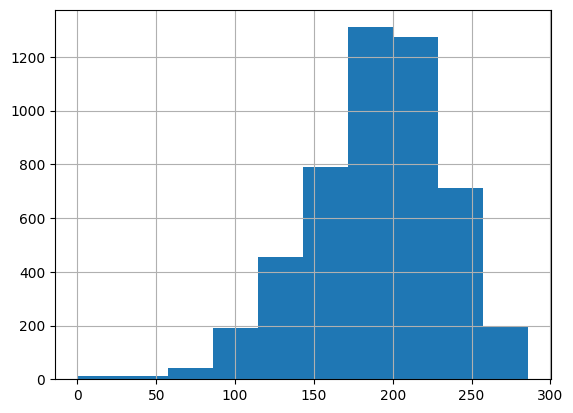

In [12]:
bark_beetle_df['canopyHeig'].hist()

Examine the correlation between the columns in the dataset, in an SNS heatmap. This could be a useful tool to identify which variables are most important for the classification.

<Axes: >

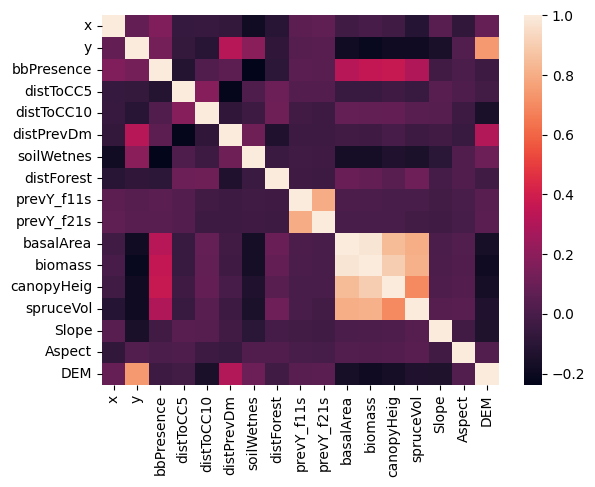

In [18]:
# Correlation Heatmap
bark_corr = bark_beetle_df.select_dtypes('number').corr()
sns.heatmap(bark_corr)

Now create a box plot of the canopy height by forest type.

<Axes: xlabel='canopyHeig', ylabel='forestType'>

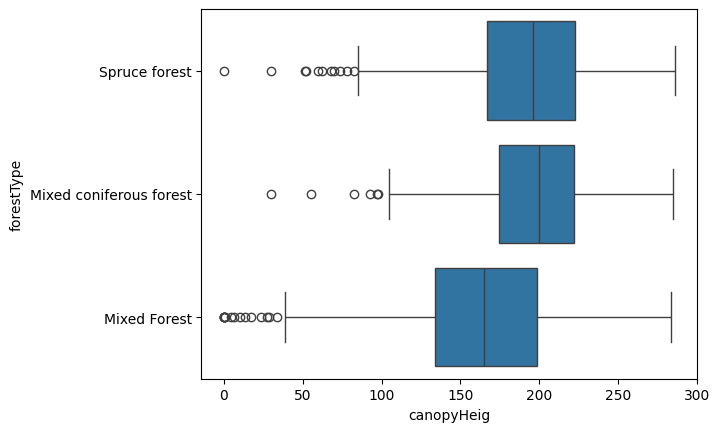

In [20]:
# Box Plot
sns.boxplot(data=bark_beetle_df, x='canopyHeig', y='forestType')

Create a violin plot of the soil wetness by forest type.

<Axes: xlabel='soilWetnes', ylabel='forestType'>

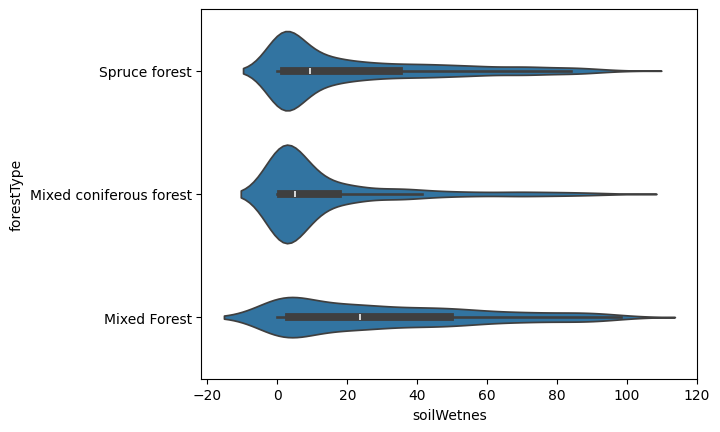

In [21]:
# Violin Plot
sns.violinplot(data=bark_beetle_df, x='soilWetnes', y='forestType')

Create a scatter plot of the canopy height by DEM, coloured by the presence of bark beetles.

<Axes: xlabel='canopyHeig', ylabel='DEM'>

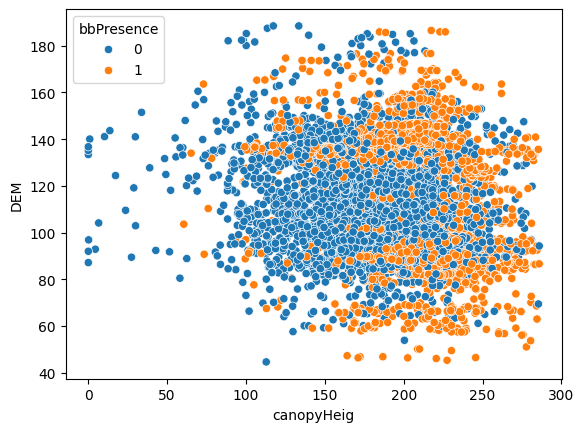

In [23]:
# Scatter Plot
sns.scatterplot(data=bark_beetle_df, x='canopyHeig', y='DEM', hue='bbPresence')

<Axes: xlabel='canopyHeig', ylabel='soilWetnes'>

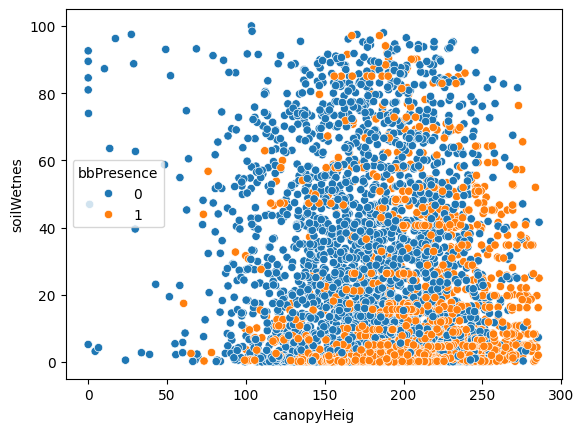

In [24]:
#create further plots according to factors who think may be associated with the presence of bark beetles
sns.scatterplot(data=bark_beetle_df, x='canopyHeig', y='soilWetnes', hue='bbPresence')

<br><br><br>
## Encoding the classification

Now we will create our equivalent label dataset. To do this, we'll use our first tool from `scikit`, the `LabelEncoder`. This usefully takes a column of data and transforms it into the format (integer labels) required for our `scikit` classifiers. We can use the `le` label encoder we create here later on to reverse the encoding.

**Run the scripts below to first import the `LabelEncoder` tools, and then create the labels dataset from the `score` column.**

In [25]:
from sklearn.preprocessing import LabelEncoder

In [26]:
# encode the columns of "forestType" and "soilType"

label_encoder_forestType = LabelEncoder()
bark_beetle_df['forestType'] = label_encoder_forestType.fit_transform(bark_beetle_df['forestType'])
label_encoder_soilType = LabelEncoder()
bark_beetle_df['soilType'] = label_encoder_soilType.fit_transform(bark_beetle_df['soilType'])


Let's have a look at the label encoders used for "forestType" and "soilType", as well as the dataframe after label encoding.
print the mappings between integer labels and textual labels for the two columns
an example output could look like:
_ForestType Mapping: {'Mixed Forest': 0, 'Mixed coniferous forest': 1, 'Spruce forest': 2}_

In [27]:
# print the mappings between integer labels and textual labels for the two columns

forestType_mapping = dict(zip(label_encoder_forestType.classes_, label_encoder_forestType.transform(label_encoder_forestType.classes_)))
print("ForestType Mapping:", forestType_mapping)

soilType_mapping = dict(zip(label_encoder_soilType.classes_, label_encoder_soilType.transform(label_encoder_soilType.classes_)))
print("SoilType Mapping:", soilType_mapping)

bark_beetle_df.head()

ForestType Mapping: {'Mixed Forest': 0, 'Mixed coniferous forest': 1, 'Spruce forest': 2}
SoilType Mapping: {'Moraine': 0, 'Organic': 1, 'Rock': 2, 'Sand': 3, 'Unspecified Sediment': 4}


,x,y,bbPresence,distToCC5,distToCC10,distPrevDm,soilWetnes,distForest,forestType,prevY_f11s,prevY_f21s,basalArea,biomass,canopyHeig,spruceVol,soilType,Slope,Aspect,DEM
0,416713.2303,6228294.732,1,741,189,3335,0.888151,10,2,0,0,32.139431,171.927032,232.953491,237.784714,0,4.282387,155.294220,81.010002
1,443073.2303,6238094.732,1,170,158,5172,36.603661,30,2,0,0,42.060974,233.726471,277.813202,352.840912,0,3.222722,288.121857,51.020001
2,443093.2303,6238064.732,1,205,133,5206,18.988880,51,2,0,0,41.751991,233.009689,280.511902,294.602600,0,4.374904,286.437500,53.660000
3,443103.2303,6238064.732,1,212,136,5210,18.988880,61,2,0,0,40.630081,223.813675,275.711304,195.438446,0,4.905051,278.612396,56.259998
4,443113.2303,6238114.732,1,184,161,5166,57.228600,63,2,0,0,39.628021,220.536499,274.916199,387.950653,0,5.145305,277.320190,56.060001


<br><br><br>
## Creating Training and Test Data Sets
The final stage in data processing involves splitting the prepared dataset into training and testing subsets. The training data will be used to create the classifier. The testing data will then be used to test the accuracy of a the classification.

Note: train_test_split will split the data according to a 75:25 split, roughly in line with convention. However, other proportions can be specified, check out the documentation for details.

In [28]:
from sklearn.model_selection import train_test_split

Now create a subset of the data which includes the predictors, which are ['distToCC5', 'distToCC10', 'distPrevDm', 'soilWetnes', 'distForest', 'prevY_f11s', 'prevY_f21s', 'basalArea', 'biomass', 'canopyHeig', 'spruceVol', 'soilType', 'Slope', 'Aspect', 'DEM']. Create this and view the top of it:

In [29]:
#checking the variable list to make sure we get all the names correct
bark_beetle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           5000 non-null   float64
 1   y           5000 non-null   float64
 2   bbPresence  5000 non-null   int64  
 3   distToCC5   5000 non-null   int64  
 4   distToCC10  5000 non-null   int64  
 5   distPrevDm  5000 non-null   int64  
 6   soilWetnes  5000 non-null   float64
 7   distForest  5000 non-null   int64  
 8   forestType  5000 non-null   int64  
 9   prevY_f11s  5000 non-null   int64  
 10  prevY_f21s  5000 non-null   int64  
 11  basalArea   5000 non-null   float64
 12  biomass     5000 non-null   float64
 13  canopyHeig  5000 non-null   float64
 14  spruceVol   5000 non-null   float64
 15  soilType    5000 non-null   int64  
 16  Slope       5000 non-null   float64
 17  Aspect      5000 non-null   float64
 18  DEM         5000 non-null   float64
dtypes: float64(10), int64(9)
me

In [30]:
#create a subset with the features (independent variables) we're first going to use:

bark_beetle_sub = bark_beetle_df[['distToCC5', 'distToCC10', 'distPrevDm', 'soilWetnes', 'distForest', 'prevY_f11s', 'prevY_f21s', 'basalArea', 'biomass', 'canopyHeig', 'spruceVol', 'soilType', 'Slope', 'Aspect', 'DEM']]

In [31]:
#view the top of the subset
bark_beetle_sub.head()

,distToCC5,distToCC10,distPrevDm,soilWetnes,distForest,prevY_f11s,prevY_f21s,basalArea,biomass,canopyHeig,spruceVol,soilType,Slope,Aspect,DEM
0,741,189,3335,0.888151,10,0,0,32.139431,171.927032,232.953491,237.784714,0,4.282387,155.294220,81.010002
1,170,158,5172,36.603661,30,0,0,42.060974,233.726471,277.813202,352.840912,0,3.222722,288.121857,51.020001
2,205,133,5206,18.988880,51,0,0,41.751991,233.009689,280.511902,294.602600,0,4.374904,286.437500,53.660000
3,212,136,5210,18.988880,61,0,0,40.630081,223.813675,275.711304,195.438446,0,4.905051,278.612396,56.259998
4,184,161,5166,57.228600,63,0,0,39.628021,220.536499,274.916199,387.950653,0,5.145305,277.320190,56.060001


We also need our dataset to be in an array in order to split it, so we do this below:

In [35]:
#convert to array:
bark_beetle_array = bark_beetle_sub.to_numpy()

The target labels (bbPresence) also need to be transformed to a 1D array for data split and model training.

In [38]:
#convert the "bbPresence" column to 1D array:
labels_array = bark_beetle_df['bbPresence'].to_numpy()

And divide into training and test data and labels:

In [39]:
train_data, test_data, train_lab, test_lab = train_test_split(bark_beetle_array, labels_array, random_state=42)

Quickly check the length of all arrays to ensure they match:

In [40]:
len(labels_array)

5000

In [41]:
len(bark_beetle_array)

5000

<BR><BR><BR>
## _k_-Nearest Neighbours
The first classifier will use is the *k*-Nearest Neighbour (*k*NN) classifier. This is a very simple method by which tested points are classified according to their proximity (in terms of attribute distance) to points that were seen during training.

In this section, we will show you how to use the *k*NN classifer in `scikit`, as well as going into detail about how you can assess the quality of the classification as part of your validation.

**IMPORTANT**: Many of the `scikit` classification methods use a very similar syntax. We will show you how to use *k*NN, but you will have to work out how to use the others. On completion, we expect you to be able to say which of the four classifiers you will test performs best in predicting the rating Score given by each user.

Across all `scikit` classifiers, a similar process and form of syntax is used.

1. First, we load the library.
2. Then, we create the classifier object, and specify any important parameters.
3. We run the `.fit()` method, sending the classifier our training dataset and accompanying labels.
4. We analyse the validate with the `.score()` method, sending the classifier our testing dataset and accompanying labels.

Let's work through this method for the *k*NN classifer.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

Now, we create the classifier object and give it a name (`knn` in our case), and run it.

On creating the object, we specify any important parameters. To understand what parameters are needed requires understanding the method and the syntax. It is worth you reading the `scikit` documentation on *k*NN at this point, which will provide you details on how to execute the method.

[This page](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) is a general description of the method. Whereas [this page](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) outlines all of the parameters and methods associated with the `KNeighborsClassifier` method. You'll need to check the documentation for any classifer you use.

As you will recall, an important element of the *k*NN approach is the specification of how many neighbours to consider when making the classification. You can see below how this parameter is defined.

You'll see from the script below that running this process is very similar to the creation of clusters and regression models over the last few weeks.

In [43]:
knn = KNeighborsClassifier(n_neighbors=10)  # creates the kNN classifier, setting it to check the 10 neighbouring points, and you're encouraged to experiment with this number

In [44]:
knn.fit(train_data, train_lab)  # executes the classifier on the training dataset

KNeighborsClassifier(n_neighbors=10)

Now we can test how well the classifier predicts the classes of our test dataset. For this stage, we send the test data and labels to the `.score()` function. This outputs a number representing the proportion of classes correctly guessed by the classifer. It requires you to pass it both the test data and test labels.

**Run the script below to see how well *kNN* performs in this case.**

In [45]:
# Evaluate the accuracy of the k-NN classifier on the test data
# The score method returns the mean accuracy on the given test data and labels
knn.score(test_data, test_lab)

0.8784

Well done, you've created and tested a classifer.

There are a number of other important ways to assess the quality of your classifier that you should be aware of.

First, you can have a look yourself at the actual results, and identify the records where predictions succeed and fail. You can do this by generating a set of predictions for each record, done using the `.predict()` method. Like `.score()`, this generates classes for a test dataset, but does take a set of labels. You will use this method in classifying any future unlabelled dataset you wish to classify.

**The predictions are recorded within an array using the script below.**

In [46]:
predictions = knn.predict(test_data)

In [47]:
predictions

array([0, 0, 0, ..., 1, 0, 1])

**Join the predicted classifications to the actual labels (from the test data) to create a new dataframe.**

In [48]:
bb_pred = pd.DataFrame(list(predictions))

In [49]:
bb_pred['bbPresence'] = pd.DataFrame(list(test_lab))

In [50]:
#and rename the first column, which has just been given the first index
bb_pred.rename(columns={0:'Prediction'}, inplace=True)

In [51]:
bb_pred

,Prediction,bbPresence
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
1245,0,0
1246,1,0
1247,1,0
1248,0,0


__Finally, create a new column in the joined dataframe indicating whether the two label values match.__

In [52]:
bb_pred['match']=None #add an empty column

In [53]:
bb_pred['match'] = np.where(bb_pred['Prediction'] == bb_pred['bbPresence'], True, False)

In [54]:
bb_pred

,Prediction,bbPresence,match
0,0,0,True
1,0,0,True
2,0,0,True
3,1,1,True
4,0,0,True
...,...,...,...
1245,0,0,True
1246,1,0,False
1247,1,0,False
1248,0,0,True


In [55]:
#check the proportion that are True
len(bb_pred.loc[bb_pred.match==True])/len(bb_pred)

0.8784

This should match the prediction score we calculated earlier.

Another useful set of tools are found in the `scikit` `metrics` library. This toolkit provides a range of measures relating to the predictive power of your classifier.

A nice and simple exploratory tool is a confusion matrix. This describes the the extents to which each class was correctly and incorrectly classified. It is generated using the `.confusion_matrix()` method, which takes the correct and predicted results. These can then be nicely visualised using the `matplotlib` matrix plotting functions.

__First, create the matrix and inspect it - what do you observe?__

In [56]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

**Now, create the confusion matrix. Does this seem clearer? Where is the majority of the error in the classification?** You can read more about the confusion matrix [here](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

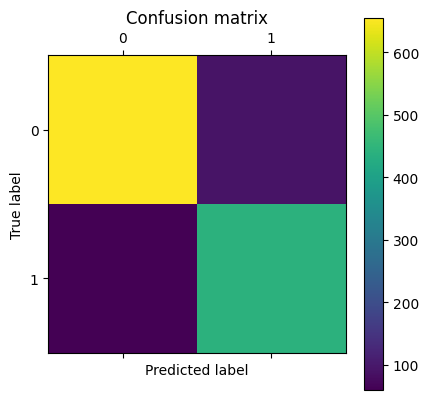

In [57]:
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

While these measures above provide an overview of the classifier quality, other measures made available in the `metrics` toolset enable a more detailed understanding. Many of the most important measures can be extracted using the `classification_report()` method, which again takes correct labels and compares them against the classifier predictions.

These metrics, called `precision`, `recall` and `f1`, all measure how well a classifier does in predicting each class relative to how often it is incorrect. As such, it allows us to identify the prediction classes where it performs well and where it performs poorly.

**Before executing the code below, look at the [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules) here to gain a little understanding of these measures**

In [59]:
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       747
           1       0.83      0.88      0.85       503

    accuracy                           0.88      1250
   macro avg       0.87      0.88      0.87      1250
weighted avg       0.88      0.88      0.88      1250



We are pleased to see that each this simple classifier performs very well. Why?

**Often more meaningful features are more useful than more powerful models (classifiers)!**

This is why engineering and learning meaningful features has been persistent endeavours in many machine learning domains. With effective features, even simple predictors (classifiers) can work surprisingly well.

<BR><BR><BR>
## Decision Trees

The first method you should try yourself is the Decision Tree.

The Decision Tree does not (necessarily) require any parameters when being setup so is quite easy to implement, just follow the same method and syntax used above. In this case, however, you'll be working with  `DecisionTreeClassifier` rather than `KNeighborsClassifier`.

Before you start, check the [documentation](http://scikit-learn.org/stable/modules/tree.html#classification) here.

**Now create a Decision Tree classifier for the same scenario and datasets used earlier** (you don't need to recreate the datasets, they are good to go already). We've given you the library import code below to get you started.

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
tree = DecisionTreeClassifier()
tree.fit(train_data, train_lab) #add the data to use

DecisionTreeClassifier()

In [63]:
#check the score
tree.score(test_data, test_lab)

0.8696

In [65]:
#predict
predictions = tree.predict(test_data)
predictions

array([0, 0, 0, ..., 0, 0, 1])

In [68]:
#add the predictions
bb_pred = pd.DataFrame(list(predictions))
bb_pred['bbPresence'] = pd.DataFrame(list(test_lab))
bb_pred.rename(columns={0:'Prediction'}, inplace=True)
bb_pred['match']=None #add an empty column
bb_pred['match'] = np.where(bb_pred['Prediction'] == bb_pred['bbPresence'], True, False)

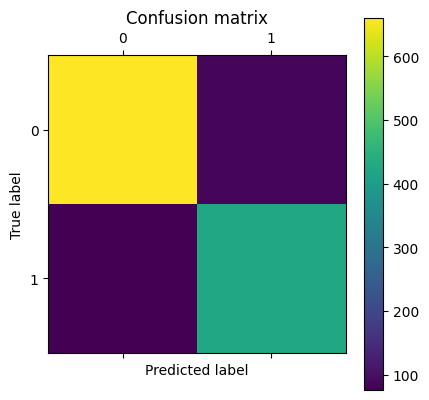

In [70]:
#create and plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#print the results


In [71]:
#print the classification report
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       747
           1       0.83      0.85      0.84       503

    accuracy                           0.87      1250
   macro avg       0.86      0.87      0.86      1250
weighted avg       0.87      0.87      0.87      1250



__How do these results compare to the _k_NN classifier? Which do you think, so far, is the best at predicting the presence of bark beetle attacks? Examine the impact of changing the `max_depth` and `min_sample_split` parameters__

These results are very similar to the kNN classifier. Predicting the presence of bark beetle attacks is how well it recognises true positives, which according to F1 Score the kNN classifier is marginally better at than the decision tree classifier.

In [90]:
#comment and explore different parameters
tree = DecisionTreeClassifier(max_depth=100, min_samples_split=5)
tree.fit(train_data, train_lab) #add the data to use
tree.score(test_data, test_lab)

0.8784

Increasing the maximum depth of the tree generally makes it better at prediction, whilst increasing the minimum samples to split increases the prediction power a little bit to a certain point.

Do you remember that a prominent advantage of decision trees is that they are explainable. Now let's visualise a real decision tree to gain some insights about how they work.

Now we have many samples and features, visualisations can be derived which are however very difficult to be interpreted. In order to have a clear visualisation, let's reduce the number of samples (first 100 samples), and only use the most important three features, derived by permutation importance analysis. The tool permutation_importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. You are encouraged to gain an understanding of it, as it could be useful for your future data analysis efforts. The tool has been integrated into [scikit-learn](https://scikit-learn.org/1.5/modules/permutation_importance.html).




Feature Importances (Mean):
 [0.         0.         0.10266667 0.         0.         0.
 0.         0.         0.         0.         0.         0.316
 0.         0.         0.08533333]
Top 3 important features: ['soilType', 'distPrevDm', 'DEM']


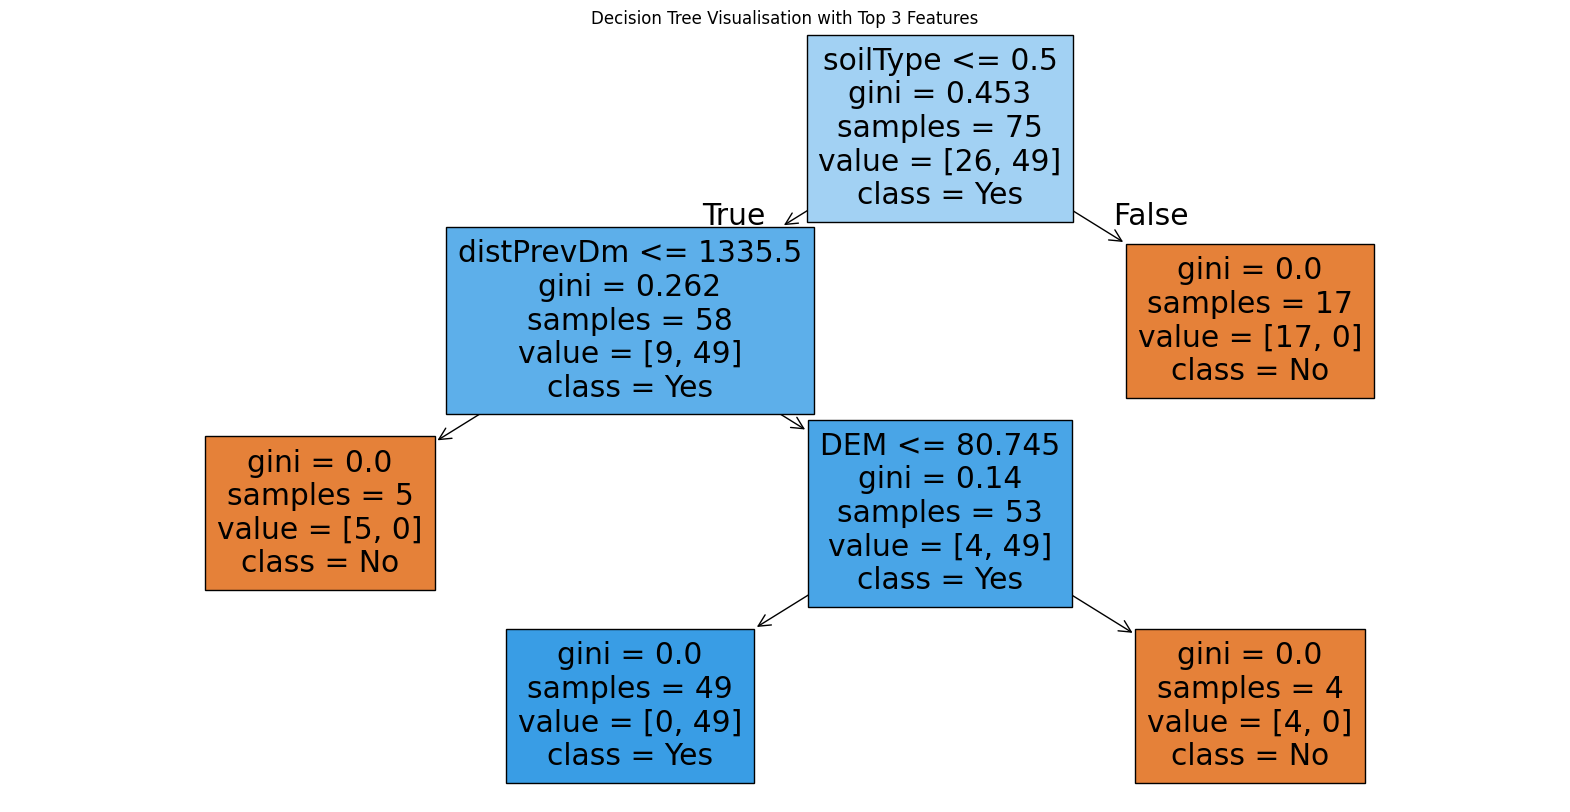

In [91]:
# Extract the first 100 samples from the dataset for a simplified analysis
bark_beetle_100 = bark_beetle_df[:100]

# Define the feature names used in the analysis, representing various environmental and biological variables
feature_names = np.array([
    'distToCC5', 'distToCC10', 'distPrevDm', 'soilWetnes', 'distForest',
    'prevY_f11s', 'prevY_f21s', 'basalArea', 'biomass', 'canopyHeig',
    'spruceVol', 'soilType', 'Slope', 'Aspect', 'DEM'
])

# Extract the features and labels (target variable) for these 100 samples
bb_features_100 = bark_beetle_100[feature_names].to_numpy()
bb_label_100 = bark_beetle_100['bbPresence'].to_numpy()

# Split the data into training and testing sets (default 75% training, 25% testing)
train_data_100, test_data_100, train_lab_100, test_lab_100 = train_test_split(
    bb_features_100, bb_label_100, random_state=42  # Added random_state for reproducibility
)

# Initialize and train a decision tree classifier on the training data
tree_100 = DecisionTreeClassifier()
tree_100.fit(train_data_100, train_lab_100)

# Now, let's determine the importance of each feature using permutation importance
from sklearn.inspection import permutation_importance

# Permutation importance measures the effect of shuffling each feature on model performance
importances = permutation_importance(tree_100, train_data_100, train_lab_100, n_repeats=10, random_state=42)
print("Feature Importances (Mean):\n", importances.importances_mean)

# Sort the features by their importance (in descending order) to identify the most influential ones
sorted_indices = np.argsort(importances['importances_mean'])[::-1]

# Extract the names of the top 3 most important features
top_features = list(feature_names[sorted_indices][:3])
print(f"Top 3 important features: {top_features}")

# Important Note: These results are based on only 100 samples, so the observed feature importance may not generalize to the full dataset.
# It's advised to refer to domain-specific research for validated findings, e.g., canopy height is identified as the most important feature in the referred paper.

# Now, let's use the top 3 important features to train another decision tree
bb_features_100_top3 = bark_beetle_100[top_features].to_numpy()

# Split the data using only the top 3 features
train_data_100_top3, test_data_100_top3, train_lab_100_top3, test_lab_100_top3 = train_test_split(
    bb_features_100_top3, bb_label_100, random_state=42)

# Train a new decision tree model based on the top 3 features
tree_100_top3 = DecisionTreeClassifier()
tree_100_top3.fit(train_data_100_top3, train_lab_100_top3)

# Visualize the decision tree structure for better understanding of the decision process
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree with a figure size large enough to read the tree details clearly
plt.figure(figsize=(20,10))
plot_tree(tree_100_top3, feature_names=top_features, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree Visualisation with Top 3 Features")
plt.show()

Now you have got the tree visually! The codes are somewhat complicated, mainly because the dataset is large and we wrote quite some codes to reduce the number of features and samples. Otherwise, this could be a simple process.

<BR><BR><BR>
## Random Forests

Next, carry out the same process using a Random Forest classifier.

Unlike the Decision Tree, the Random Forest requires you to specify a parameter called `n_estimators`. This parameter specifies how many trees should be created in the construction of the whole forest. The more trees you choose, the longer the classification process will take to run.

So first, read up on the `scikit` Random Forest method [here](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees), and identify how you can set the `n_estimators` parameter and then follow through the same classifier creation and testing process used above.

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
forest = RandomForestClassifier(n_estimators=200)

In [106]:
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)

0.9048

In [107]:
predictions = forest.predict(test_data)

In [108]:
#add the predictions
bb_pred = pd.DataFrame(list(predictions))
bb_pred['bbPresence'] = pd.DataFrame(list(test_lab))
bb_pred.rename(columns={0:'Prediction'}, inplace=True)
bb_pred['match']=None #add an empty column
bb_pred['match'] = np.where(bb_pred['Prediction'] == bb_pred['bbPresence'], True, False)

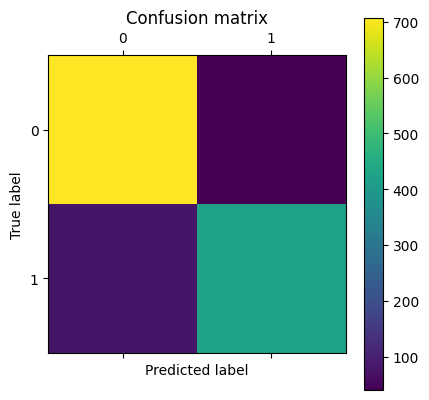

In [109]:
#create and plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [110]:
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       747
           1       0.91      0.84      0.88       503

    accuracy                           0.90      1250
   macro avg       0.91      0.89      0.90      1250
weighted avg       0.91      0.90      0.90      1250



**How well does this model perform relative to the Decision Tree and *k*-Nearest Neighbour approaches? How does varying the number of trees impact on the quality and speed of prediction?**

This model performs better than the decision tree and kNN approaches according to the f1-score, particularly with predicting the presence of bark beetle attacks. Increasing the number of trees only makes the quality of predicition better, but also it takes more time to compute.

In [128]:
#comment and explore changing the parameters
forest = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=2)
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)

0.9008

Increasing the min_samples_split reduces the efficacy of the prediction. Increasing max_depth too much can reduce the efficacy of the prediction, whilst making it too low also reduces efficacy, it seems to work best at around 15

<BR><BR><BR>
## Naive Bayes

Next, we'll put Naive Bayes into practice.

First, read up on the `scikit` Random Forest method [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB), and identify how you can set the `n_estimators` parameter and then follow through the same classifier creation and testing process used above.

In [129]:
from sklearn.naive_bayes import GaussianNB

In [130]:
NB = GaussianNB()

In [131]:
NB.fit(train_data, train_lab)

GaussianNB()

In [133]:
NB.score(test_data, test_lab)

0.6704

In [134]:
predictions = NB.predict(test_data)

In [135]:
#add the predictions
bb_pred = pd.DataFrame(list(predictions))
bb_pred['bbPresence'] = pd.DataFrame(list(test_lab))
bb_pred.rename(columns={0:'Prediction'}, inplace=True)
bb_pred['match']=None #add an empty column
bb_pred['match'] = np.where(bb_pred['Prediction'] == bb_pred['bbPresence'], True, False)

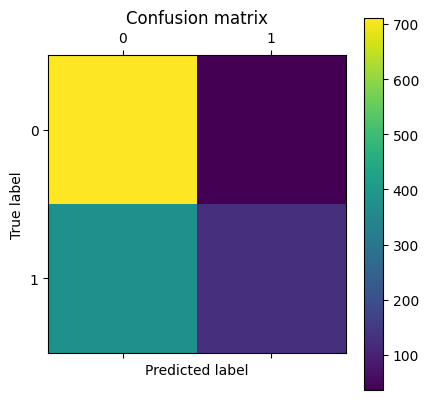

In [136]:
#create and plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [137]:
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.65      0.95      0.78       747
           1       0.78      0.25      0.38       503

    accuracy                           0.67      1250
   macro avg       0.72      0.60      0.58      1250
weighted avg       0.70      0.67      0.62      1250



__How well does this model perform relative to the Decision Tree, *k*-Nearest Neighbour and Random Forest approaches?__

This model is by far the worst performing of all the models so far

In [138]:
#comment and explore changing the parameters
NB = GaussianNB()
NB.fit(train_data, train_lab) #add the data to use
NB.score(test_data, test_lab)

0.6704

<BR><BR><BR>
## The Perceptron

Finally, we'll have a quick go at implementing the Perceptron, our deep learning approach. The approach is the same but the parameters are a little more complex. Read up on this [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

In [139]:
from sklearn.neural_network import MLPClassifier

In [140]:
Perceptron = MLPClassifier()

In [141]:
Perceptron.fit(train_data, train_lab)

MLPClassifier()

In [142]:
Perceptron.score(test_data, test_lab)

0.8032

In [143]:
predictions = Perceptron.predict(test_data)

In [144]:
#add the predictions
bb_pred = pd.DataFrame(list(predictions))
bb_pred['bbPresence'] = pd.DataFrame(list(test_lab))
bb_pred.rename(columns={0:'Prediction'}, inplace=True)
bb_pred['match']=None #add an empty column
bb_pred['match'] = np.where(bb_pred['Prediction'] == bb_pred['bbPresence'], True, False)

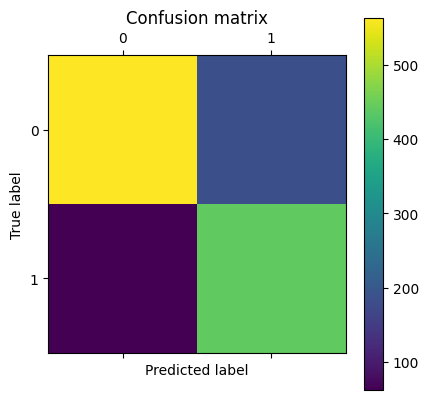

In [145]:
#create and plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [146]:
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       747
           1       0.71      0.88      0.78       503

    accuracy                           0.80      1250
   macro avg       0.80      0.82      0.80      1250
weighted avg       0.82      0.80      0.81      1250



__How do all of these methods compare? Which do you think is the most effective at predicting the review scores, and why?__

This method is not very effective. More effective than naive bayes but less effective than the other two.

In [ ]:
#compare the classifiers here

<br><br><br>
## Formative Homework Questions

Now it's your turn to try out adding additional predictors to the models. You'll need to create k-Nearest Neighbors (k-NN), Decision Tree, Random Forest, and Naive Bayes models, and report the results, using the link below.

For classification, try out different parameters and methods to see which feels most comfortable and intuitive to you. Remember to visualize and investigate all the individual variables before adding them to your models! For the following questions please also work with the first 5,000 rows of the dataset, but you are free the use the entire dataset for explorations.

__Question 1:__ Create a k-Nearest Neighbors (k-NN) classifier which predicts the presence of bark beetle attacks using the features: `distToCC5`, `soilWetnes`, and `canopyHeig`.  Calculate the accuracy, precision, recall, and F1-score under different values of n_neighbors of 3, 5, 10, 15, and find out which gives the best performance. Please use random state 42 for data split. <br>

__Question 2:__ Create a Random Forest classifier using the same parameters as for question 1. Experiment with different numbers of trees (`n_estimators`) of 10, 20, 50, 100.  <br>

__Question 3:__ Using all the features not including x, y, and bbPresence, create MLP (perceptron) classifiers with different hyperparameters, including hidden_layer_sizes and activation. Answer the question: when hidden_layer_size is set 64, which activation function, among ‘logistic’, ‘tanh’, ‘relu’, gives the best performance? For this question, initiate the model using this line of code:
`mlp = MLPClassifier(hidden_layer_sizes=(64,), activation=activation, random_state=42)`  
<br>

<br>

# Question 1

In [160]:
#create a subset with the features (independent variables) we're first going to use:

bark_beetle_sub_hwk = bark_beetle_df[['distToCC5', 'soilWetnes', 'canopyHeig']]

In [161]:
#convert to array:
bark_beetle_array_hwk = bark_beetle_sub_hwk.to_numpy()

In [162]:
#convert the "bbPresence" column to 1D array:
labels_array = bark_beetle_df['bbPresence'].to_numpy()

In [163]:
train_data, test_data, train_lab, test_lab = train_test_split(bark_beetle_array_hwk, labels_array, random_state=42)

In [164]:
print(len(bark_beetle_array_hwk), len(labels_array))

5000 5000


## n_neighbours = 3

In [170]:
knn = KNeighborsClassifier(n_neighbors=3)  # creates the kNN classifier, setting it to check the 10 neighbouring points, and you're encouraged to experiment with this number
knn.fit(train_data, train_lab)
knn.score(test_data, test_lab)
predictions = knn.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       747
           1       0.67      0.65      0.66       503

    accuracy                           0.73      1250
   macro avg       0.72      0.72      0.72      1250
weighted avg       0.73      0.73      0.73      1250



## n_neighbours = 5

In [171]:
knn = KNeighborsClassifier(n_neighbors=5)  # creates the kNN classifier, setting it to check the 10 neighbouring points, and you're encouraged to experiment with this number
knn.fit(train_data, train_lab)
knn.score(test_data, test_lab)
predictions = knn.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       747
           1       0.69      0.67      0.68       503

    accuracy                           0.75      1250
   macro avg       0.74      0.73      0.74      1250
weighted avg       0.75      0.75      0.75      1250



## n_neighbours = 10

In [173]:
knn = KNeighborsClassifier(n_neighbors=10)  # creates the kNN classifier, setting it to check the 10 neighbouring points, and you're encouraged to experiment with this number
knn.fit(train_data, train_lab)
knn.score(test_data, test_lab)
predictions = knn.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       747
           1       0.71      0.63      0.67       503

    accuracy                           0.75      1250
   macro avg       0.74      0.73      0.73      1250
weighted avg       0.74      0.75      0.74      1250



## n_neighbours = 15

In [174]:
knn = KNeighborsClassifier(n_neighbors=15)  # creates the kNN classifier, setting it to check the 10 neighbouring points, and you're encouraged to experiment with this number
knn.fit(train_data, train_lab)
knn.score(test_data, test_lab)
predictions = knn.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       747
           1       0.69      0.66      0.68       503

    accuracy                           0.74      1250
   macro avg       0.73      0.73      0.73      1250
weighted avg       0.74      0.74      0.74      1250



# Question 2

## n_estimators = 10

In [175]:
forest = RandomForestClassifier(n_estimators=10)
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)
predictions = forest.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       747
           1       0.76      0.67      0.72       503

    accuracy                           0.78      1250
   macro avg       0.78      0.77      0.77      1250
weighted avg       0.78      0.78      0.78      1250



## n_estimators = 20

In [176]:
forest = RandomForestClassifier(n_estimators=20)
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)
predictions = forest.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       747
           1       0.78      0.70      0.74       503

    accuracy                           0.80      1250
   macro avg       0.79      0.78      0.79      1250
weighted avg       0.80      0.80      0.80      1250



## n_estimators = 50

In [177]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)
predictions = forest.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       747
           1       0.78      0.72      0.75       503

    accuracy                           0.80      1250
   macro avg       0.80      0.79      0.79      1250
weighted avg       0.80      0.80      0.80      1250



## n_estimators = 100

In [178]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(train_data, train_lab) #add the data to use
forest.score(test_data, test_lab)
predictions = forest.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       747
           1       0.77      0.74      0.76       503

    accuracy                           0.81      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.81      0.81      0.81      1250



# Question 3

In [183]:
#create a subset with the features (independent variables) we're first going to use:

bark_beetle_sub_3 = bark_beetle_df[['distToCC5', 'distToCC10', 'distPrevDm', 'soilWetnes', 'distForest', 'prevY_f11s', 'prevY_f21s', 'basalArea', 'biomass', 'canopyHeig', 'spruceVol', 'soilType', 'Slope', 'Aspect', 'DEM']]
bark_beetle_array_3 = bark_beetle_sub_3.to_numpy()
labels_array = bark_beetle_df['bbPresence'].to_numpy()
train_data, test_data, train_lab, test_lab = train_test_split(bark_beetle_array_3, labels_array, random_state=42)

## Logistic

In [185]:
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='logistic', random_state=42)
mlp.fit(train_data, train_lab)
mlp.score(test_data, test_lab)
predictions = mlp.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       747
           1       0.78      0.80      0.79       503

    accuracy                           0.83      1250
   macro avg       0.82      0.82      0.82      1250
weighted avg       0.83      0.83      0.83      1250



## Tanh

In [186]:
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='tanh', random_state=42)
mlp.fit(train_data, train_lab)
mlp.score(test_data, test_lab)
predictions = mlp.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       747
           1       0.72      0.68      0.70       503

    accuracy                           0.77      1250
   macro avg       0.76      0.75      0.75      1250
weighted avg       0.76      0.77      0.77      1250



## Relu

In [187]:
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', random_state=42)
mlp.fit(train_data, train_lab)
mlp.score(test_data, test_lab)
predictions = mlp.predict(test_data)
print(metrics.classification_report(test_lab, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       747
           1       0.75      0.63      0.68       503

    accuracy                           0.77      1250
   macro avg       0.76      0.74      0.75      1250
weighted avg       0.77      0.77      0.76      1250

